# Continuous Optimization

In this tutorial we will go into some of the details of optimizing a Euclidean landscape in continuous space.

In [28]:
# Fix PROJ path ---------------------------------------------------------------
import os; 
os.environ['PROJ_LIB']=r'/opt/conda/pkgs/proj-9.2.1-ha5fc9e9_0/share/proj'
# Load libraries --------------------------------------------------------------
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MGSurvE as srv
%matplotlib inline
# Setup data path and ID ------------------------------------------------------
(ID, OUT_PTH) = ('Continuous_GA', './out/')

In [29]:
(PTS_NUM, PTS_TYPE) = (10, 2)
RADII = (-100, 100)
# Generate pointset -----------------------------------------------------------
xy = srv.ptsRegularGrid(PTS_NUM, (RADII, RADII)).T
pType = np.random.choice(PTS_TYPE, xy.shape[1])
points = pd.DataFrame({'x': xy[0], 'y': xy[1], 't': pType})

In [30]:
msk = [
    [0.50, 0.60],
    [0.80, 0.20]
]
movKer = {'params': [.075, 1.0e-10, math.inf], 'zeroInflation': .75}

In [31]:
nullTraps = [0, 0, 0, 0]
traps = pd.DataFrame({
    'x': nullTraps, 'y': nullTraps,
    'sid': nullTraps,
    't': [0, 0, 1, 1], 'f': nullTraps
})
tKer = {
    0: {'kernel': srv.exponentialDecay, 'params': {'A': .5, 'b': .1}},
    1: {'kernel': srv.exponentialDecay, 'params': {'A': .5, 'b': .125}}
}

In [32]:
lnd = srv.Landscape(
    points, 
    maskingMatrix=msk, 
    kernelParams={'params': srv.MEDIUM_MOV_EXP_PARAMS, 'zeroInflation': .25},
    traps=traps, trapsKernels=tKer
)

In [37]:
(lnd, logbook) = srv.optimizeTrapsGA(
    lnd, pop_size='auto', generations=1000,
    mating_params='auto', mutation_params='auto', selection_params='auto',
    fitFuns={'outer': np.mean, 'inner': np.max}, verbose=False
)

/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


(<Figure size 1500x1500 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2d823b160>)

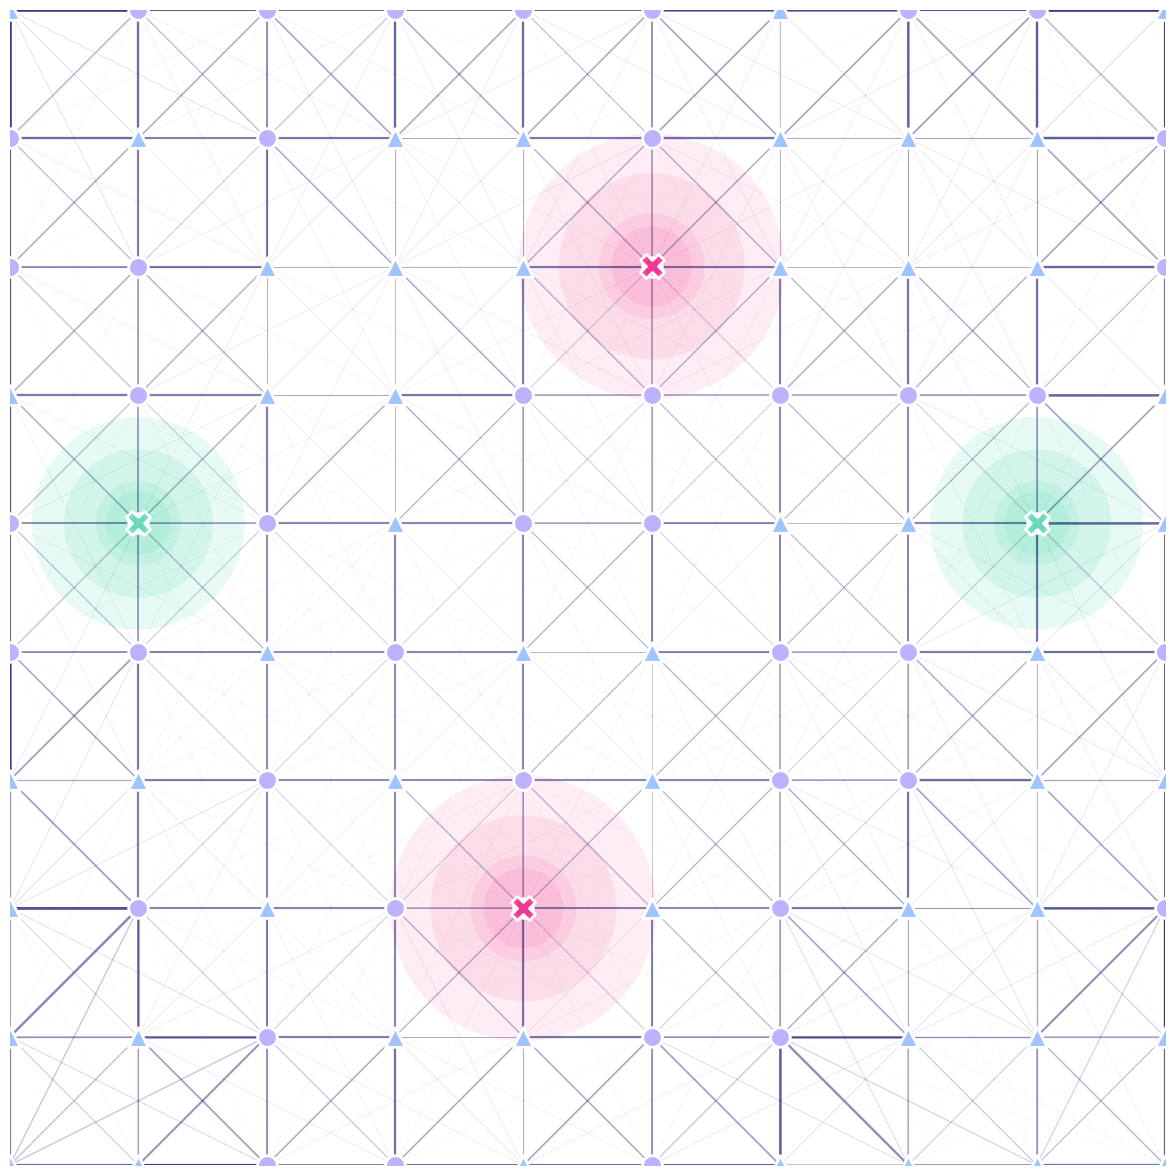

In [38]:
(fig, ax) = plt.subplots(1, 1, figsize=(15, 15), sharey=False)
lnd.plotSites(fig, ax, size=200)
lnd.plotTraps(fig, ax)
lnd.plotMaskedMigrationNetwork(fig, ax, alphaMin=.6, lineWidth=25)
srv.plotClean(fig, ax, bbox=lnd.landLimits)